# Pyleoclim UI Tutorial: Efficient & Flexible Timeseries Analysis

In this tutorial, we will be talking about how to use the newly designed user interface (UI) of *Pyleoclim* to perform efficient and flexible timeseries analysis. By UI, we mean a collection of **methods** that are desgined for users to interact with timeseries **objects**.

The workflow of timeseries analysis is simple: 1. we get some timeseries, 2. we perform some preprocessing to clean up the timeseries, 3. we perform some analysis on the cleaned timeseries, and 4. we visualize the analysis results.

Given this workflow, the logic of the UI is also intuitive: 1. we define some timeseries **objects**, 2. we perform some preprocessing **methods** to clean up the timeseries **objects**, 3. we perform some analysis **methods** on the cleaned timeseries **objects**, and 4. we perform some plotting **methods** to visualize our analysis results.

In the following, we will utilize some example data to show how we can use the UI of *Pyleoclim* to perform efficient and flexible timeseries analysis, so that we are able to liberate our mind from complicated details of the algorithms and think more about higher-level questions.

First of all, let's import the *Pyleoclim* package and other useful packages, as well as the example data!

In [1]:
import pyleoclim as pyleo
import scipy.io as sio

data = sio.loadmat('../example_data/wtc_test_data_nino.mat')
air = data['air'][:, 0]
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]

## Step 1. define timseries **objects**

It's intuitive to define timeseries **objects**, we just feed the time data to the `time` property of the `Series` object of *Pyleoclim*, and the value data to the `value` property.  

In [2]:
ts_air = pyleo.Series(time=t, value=air)
ts_nino = pyleo.Series(time=t, value=nino)

Now that the objects are defined, it's ready to do some visualization.
Note that the visualization style has been automatically customized when we import the *Pyleoclim* package. 

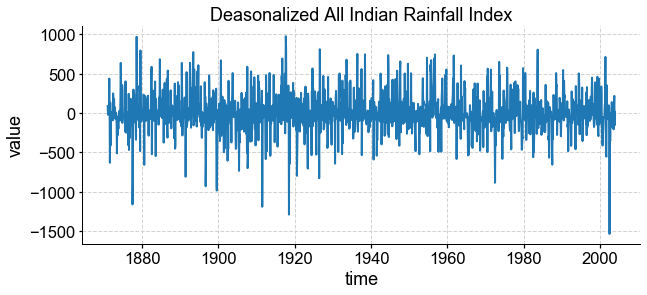

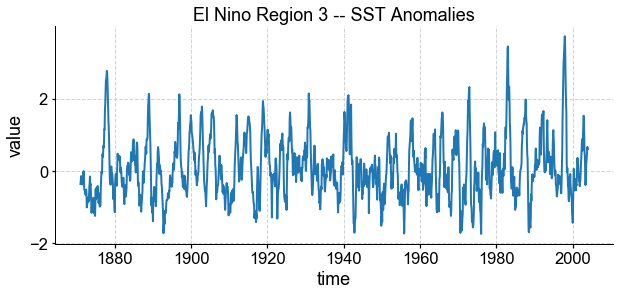

In [3]:
fig, ax = ts_air.plot(title='Deasonalized All Indian Rainfall Index')
fig, ax = ts_nino.plot(title='El Nino Region 3 -- SST Anomalies')

## Step 2. preprocessing

There are a couple of preprocessing **methods** collected in *Pyleoclim*, such as `standardize()`, `detrend()`, `gaussianize()`, `clean()`, etc.
We will take `standardize()` as an example, which is optional in this example case.

In the below, we standardize the `ts_nino` **object** by calling the `standardize()` **method**, and name the standardized timeseries object as `ts_nino_std`, and then we plot both `ts_nino` and `ts_nino_std` for comparison.

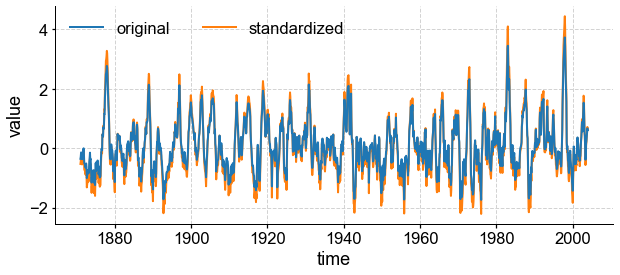

In [4]:
ts_nino_std = ts_nino.standardize()

fig, ax = ts_nino.plot(label='original', mute=True, zorder=99)  # use mute=True to hold the showing of the figure
ax = ts_nino_std.plot(label='standardized', ax=ax, lgd_kwargs={'ncol': 2})
pyleo.showfig(fig)

## Steps 3 & 4. analysis of the data and visualization of the results

The current version of *Pyleoclim* supports analysis such as spectral analysis, wavelet analysis, correlation analysis, coherence analysis, and causality analysis, etc., which we will cover in the following one by one.

### Spectral analysis

It's simple to perform spectral analysis -- call the `spectral()` method and it will yield a `PSD` (power spectral density) object.
The default method `spectral(method='wwz')` (Weighted Wavelet Z-transform) can handle both evenly-spaced data and unevenly-spaced data, while some other methods like `spectral(method='mtm')` (Multi-Taper Method) can handle only evenly-spaced data.
The `wwz` method is essentially an wavelet tranform algorithm and therefore much slower than the `mtm` method.
For our example data, both methods apply.

In [5]:
psd_wwz = ts_nino_std.spectral()  # method='wwz' by default 
psd_mtm = ts_nino_std.spectral(method='mtm')  # method='wwz' 

Now let's plot the power spectral density results.

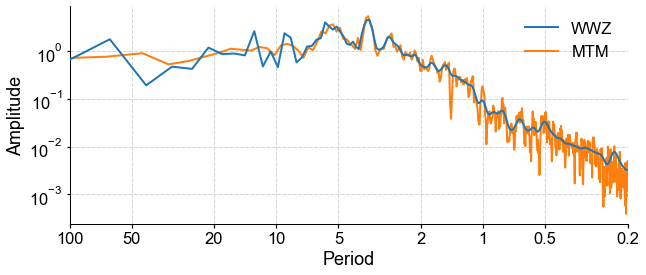

In [6]:
fig, ax = psd_wwz.plot(label='WWZ', mute=True, zorder=99)
ax = psd_mtm.plot(ax=ax, label='MTM')
pyleo.showfig(fig)

To make sense of our result, namely to identify the periodocity of our data, we need to perform some significance test.
Currently, *Pyleoclim* supports the test with AR(1) surrogates, and we can perform the test by simply calling the `signif_test()` method.

In [7]:
psd_mtm_signif = psd_mtm.signif_test(qs=[0.99])  # use qs to specify the AR(1) threshold

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:15<00:00, 12.98it/s]


Now if we the plot `psd_mtm_signif` object by calling the `plot()` method, the PSD along with the AR(1) threshold curve will be plotted, based on which we are able to identify the significant cycles.

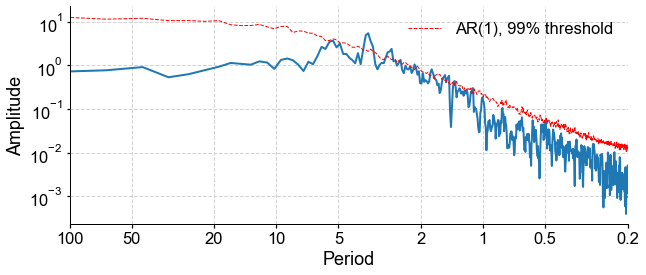

In [8]:
fig, ax = psd_mtm_signif.plot()

### Wavelet analysis

The current version of *Pyleoclim* only supports the `wwz` method for wavelet analysis, to perform which we simply call the `wavelet()` method, and then a `Scalogram` object will be created.

In [9]:
scal = ts_nino_std.wavelet()

Once we get the scalogram object, we can simply plot it by calling the `plot()` method.

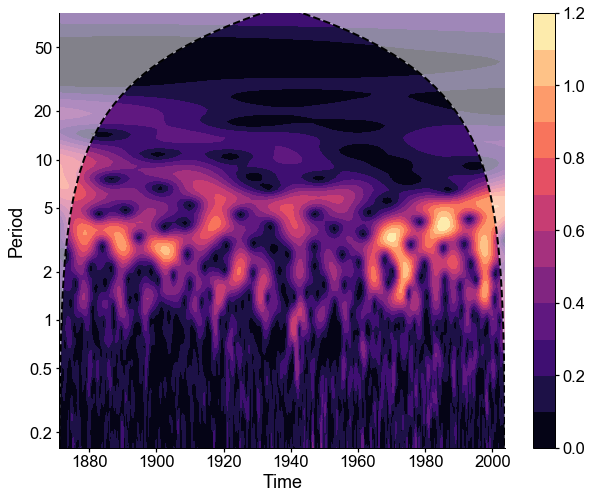

In [10]:
fig, ax = scal.plot()

Again, we'd like to perform a significance test. By default, 200 AR(1) tests will be performed, but due to the fact that the `wwz` method is slow, we will perform only 10 test in this tutorial as an example (which is not enough for any serious work).

In [11]:
scal_signif = scal.signif_test(number=10, qs=[0.99])

Performing wavelet analysis on surrogates: 100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


Now let's plot the scalogram with significance test by calling the `plot()` method.

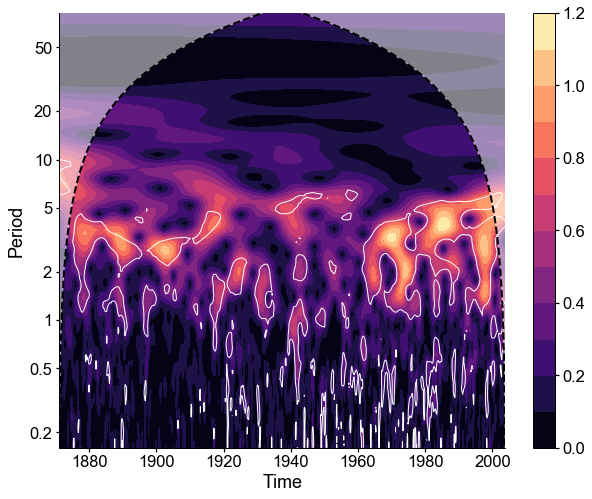

In [12]:
fig, ax = scal_signif.plot()

## Correlation analysis

Often we need to calculate the correlation between two timeseries, and it's simple to do it with *Pyleoclim*.
We just call the `correlation()` method with another timeseries object as the positional argument.

In [13]:
corr_res = ts_nino.correlation(ts_air)
print(corr_res)

{'r': -0.15239413332839044, 'signif': True, 'pvalue': 0.0}


## Causality analysis

Correlation doesn't necessarily imply causal relationship, and we need to perform causality anslysis to get more idea.
To perform causality analysis, we just call the `causality()` method with another timeseries object as the positional argument.

In [14]:
caus_res = ts_nino.causality(ts_air)
print(caus_res)

Calculating causality between surrogates: 100%|██████████| 1000/1000 [00:00<00:00, 1935.83it/s]

{'T21': 0.005840218794983322, 'tau21': 0.04731826159975568, 'Z': 0.12342420447275003, 'signif_qs': [0.005, 0.025, 0.05, 0.95, 0.975, 0.995], 'T21_noise': array([-0.00093968, -0.00058204, -0.00047092,  0.0005229 ,  0.00071209,
        0.00097524]), 'tau21_noise': array([-0.00829214, -0.00513816, -0.00416416,  0.00456974,  0.00620283,
        0.00848127])}


## Wavelet Coherence

It's also very useful to calculate the wavelet coherence between two timeserise, to perform which, we just call the `wavelet_coherence()` method with another timeseries object as the positional argument.
By defaul, `wwz` method is used to perform the wavelet transform.

In [15]:
coh = ts_nino.wavelet_coherence(ts_air)

We can visualize the coherence by calling the `plot()` method.

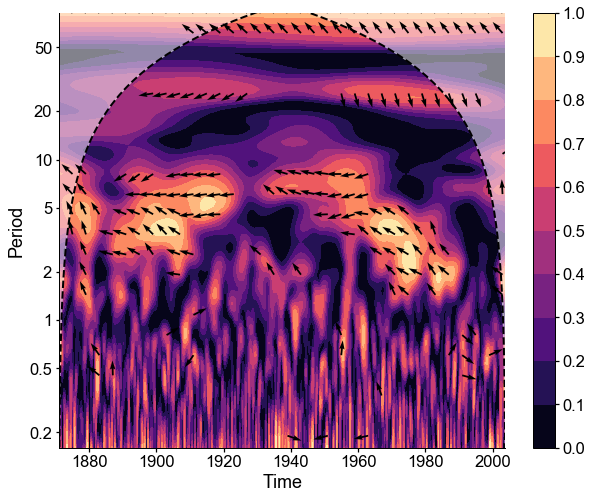

In [16]:
fig, ax = coh.plot(phase_style={'skip_x': 50})  # skip_x is used to adjust the density of the arrows in the x-axis direction

Again, to perform significance test, just call the `signif_test()` method.
By default, 200 AR(1) tests will be performed, and we use 10 tests as an example in this tutorial.

In [17]:
coh_signif = coh.signif_test(number=10, qs=[0.99])  # qs 

Performing wavelet coherence on surrogate pairs: 100%|██████████| 10/10 [01:55<00:00, 11.58s/it]


Again, we can visualize the coherence with the contour of significance level by calling the plot() method.

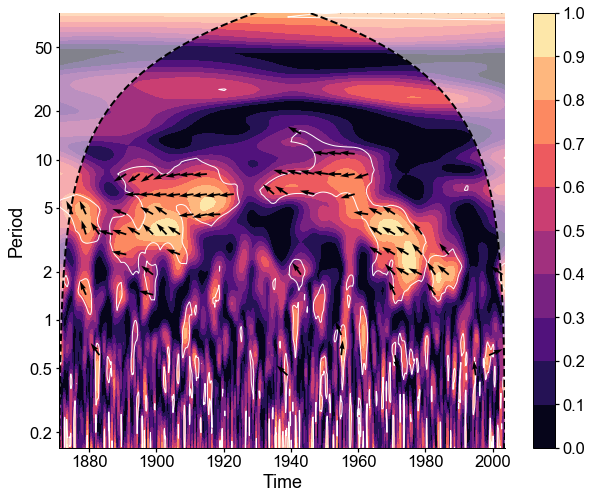

In [19]:
fig, ax = coh_signif.plot(phase_style={'skip_x': 50})

## One more thing: method cascading

Life is short. The UI provides a very cool feature to make our life easier -- "method cascading". This feature provides the opportunity to perform a multi-step workflow in just one line of command.

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:15<00:00, 12.77it/s]


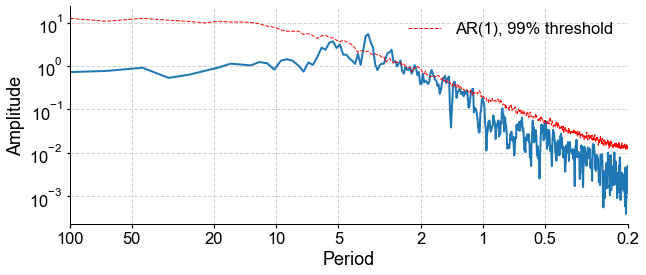

In [20]:
# spectral analysis with significance test
fig, ax = ts_nino.standardize().spectral(method='mtm').signif_test(qs=[0.99]).plot()

Performing wavelet analysis on surrogates: 100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


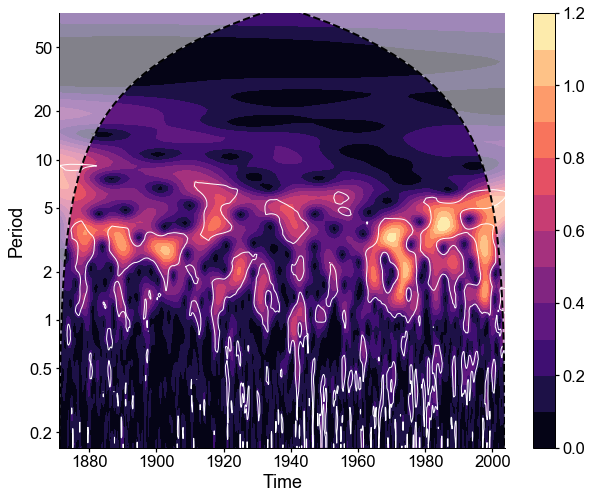

In [22]:
# wavelet analysis with significance test
fig, ax = ts_nino.standardize().wavelet().signif_test(number=10, qs=[0.99]).plot()

Performing wavelet coherence on surrogate pairs: 100%|██████████| 10/10 [02:36<00:00, 15.67s/it]


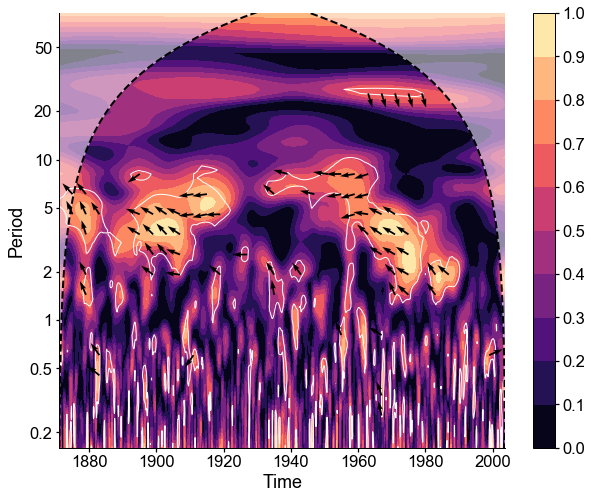

In [23]:
# wavelet coherence analysis with significance test
fig, ax = ts_nino.wavelet_coherence(ts_air).signif_test(number=10, qs=[0.99]).plot(phase_style={'skip_x': 50})

## Summary

To summarize, below is the hierarchy of the UI of *Pyleoclim*:
![](figs/Series_hierarchy.png)